# Goal: gather statistics on average overhead of a cosmic ray, based on the detection statistics generated in the previous notebook. Also, experiment with adding redundancy in the factory.

### Note: much of the code written here is now being implemented in `ray_delay/factory_simulator.py` for easier use in further experiments.

In [50]:
import sys
sys.path.append('../')

import numpy as np
from numpy.typing import NDArray
import scipy
from dataclasses import dataclass
from typing import Callable
import matplotlib.pyplot as plt
import itertools
import mpmath
import dill

from ray_delay.ray_detector import RayDetectorSpec
from stim_surface_code import patch

import qc_utils.stats

mpmath.mp.dps = 50

After the high-accuracy simulations in notebooks 02-05, we are now zooming out
to look at algorithm-level performance. To do this, we must abandon Stim
simulations and instead adopt a simpler model of cosmic rays.

In [2]:
def idx(l):
    return sum(x << i for i, x in enumerate(reversed(l)))

In [12]:
class MagicStateFactory:
    """TODO
    """
    def __init__(
            self, 
            dx: int = 7,
            dz: int = 7,
            dm: int = 7,
        ):
        """Initializes the factory.

        Args:
            dx: X code distance for each patch.
            dz: Z code distance for each patch.
            dm: Temporal code distance.
        """
        self.dx = dx
        self.dz = dz
        self.dm = dm

@dataclass
class SimulationResult:
    """Contains the results of a many-round magic state factory simulation.

    Attributes:
        TODO
    """
    ray_history: list[tuple[int, tuple[int, int]]]

def boolean_array_BFS(
        array: NDArray, 
        start: tuple[int, int], 
        end: tuple[int, int] | None = None,
    ) -> dict[tuple[int, int], list[tuple[int, int]]] | list[tuple[int, int]] | None:
    """Use breadth-first search to find a path through the array from start to
    end. False values in the array are considered obstacles.

    Args:
        array: 2D boolean array.
        start: Starting coordinates.
        end: Ending coordinates, or None to find all paths.
    
    Returns:
        If end is None, a dictionary of all paths from start to any True
        coordinate pair in the array. If end is not None, a list of coordinates
        representing the shortest path from start to end, or None if there is no
        path. 
    """
    frontier = [start]
    paths_to = {start: [start]}
    while len(frontier) > 0:
        current = frontier[0]
        frontier = frontier[1:]
        if current == end:
            break
        neighbors = [
            (current[0]+1, current[1]), 
            (current[0]-1, current[1]), 
            (current[0], current[1]+1), 
            (current[0], current[1]-1)
        ]
        for n in neighbors:
            if n not in paths_to and n[0] >= 0 and n[0] < array.shape[0] and n[1] >= 0 and n[1] < array.shape[1] and array[n]:
                paths_to[n] = paths_to[current] + [n]
                frontier.append(n)

    if end is None:
        return paths_to
    else:
        if end not in paths_to:
            return None
        else:
            return paths_to[end]

def boolean_array_all_pairs_BFS(array: NDArray) -> dict[tuple[int, int], dict[tuple[int, int], list[tuple[int, int]]]]:
    """Compute all pairs shortest paths.
    
    TODO
    """
    all_paths = {}
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i,j]:
                all_paths[(i,j)] = boolean_array_BFS(array, (i,j))
    return all_paths

class Redundant15To1(MagicStateFactory):
    """TODO
    """
    def __init__(
            self, 
            dx: int = 7,
            dz: int = 7,
            dm: int = 7,
            num_redundant_cols: int = 0,
            redundant_top_routing_space: int = 0,
            redundant_bot_routing_space: int = 0,
            patch_offline_duration: float = 30e-3,
            cycle_time: float | None = None,
            cache_cycles_per_distillation: bool = False,
        ):
        """Initializes the factory, using a layout from litinski_magic_2019.

        Args:
            dx: X code distance for each patch.
            dz: Z code distance for each patch.
            dm: Temporal code distance.
            num_redundant_cols: Number of redundant patches to include.
            redundant_top_routing_space: Number of redundant rows to include
                above the top routing space.
            redundant_bot_routing_space: Number of redundant rows to include
                below the bottom routing space.
            patch_offline_duration: Amount of time (in seconds) a patch is taken
                offline when a ray is detected.
            cache_cycles_per_distillation: If True, store results of previous
                calls to _cycles_per_distillation() to avoid redundant
                calculations.
        """
        super().__init__(dx, dz, dm)

        self.patch_offline_duration = patch_offline_duration

        self.logical_qubit_row = 1 + redundant_top_routing_space

        num_rows = 3 + redundant_top_routing_space + redundant_bot_routing_space
        num_cols = 5 + num_redundant_cols
        row_heights = np.full(num_rows, self.dx)
        col_widths = np.array([self.dx] + [self.dz]*4 + [self.dx]*num_redundant_cols)

        self.num_patches = num_rows * num_cols
        self.patch_indices = np.reshape(np.arange(self.num_patches), (num_rows, num_cols))
        self.patch_coords_from_idx = np.zeros((self.num_patches, 2), int)
        for idx in range(self.num_patches):
            self.patch_coords_from_idx[idx] = [idx // self.patch_indices.shape[1], idx % self.patch_indices.shape[1]]
        self.patch_offline_time_remaining = np.zeros(self.num_patches, float)

        # use stim_surface_code.patch to generate the physical qubit array
        # TODO: currently does not account for extra 4*dm space needed for magic
        # state injection (see figs. 10-11 of Litinski). Is this important?
        surface_code_patch = patch.SurfaceCodePatch(num_rows*dx + (num_rows-1), (1+num_redundant_cols)*dx + 4*dz + (num_cols-1), dm)
        self.physical_qubit_array = np.array([[(q.idx if q is not None else -1) for q in row] for row in surface_code_patch.device], int)
        self.physical_qubit_coords_from_idx = np.zeros((len(surface_code_patch.all_qubits), 2), int)
        for q in surface_code_patch.all_qubits:
            self.physical_qubit_coords_from_idx[q.idx] = q.coords
        if cycle_time is None:
            self.cycle_time = surface_code_patch.cycle_time()
        else:
            self.cycle_time = cycle_time

        # maps each physical qubit to a patch index
        self.num_phys_qubits = len(surface_code_patch.all_qubits)
        self.patch_idx_from_physical_qubit_idx = np.full(self.num_phys_qubits, -1, dtype=int)
        for row in range(num_rows):
            min_phys_row = np.sum(2*row_heights[:row]+1) + row
            max_phys_row = min_phys_row + 2*row_heights[row]+1
            for col in range(num_cols):
                min_phys_col = np.sum(2*col_widths[:col]+1) + col
                max_phys_col = min_phys_col + 2*col_widths[col]+1
                for phys_row in range(min_phys_row, max_phys_row):
                    for phys_col in range(min_phys_col, max_phys_col):
                        phys_idx = self.physical_qubit_array[phys_row, phys_col]
                        if phys_idx != -1:
                            self.patch_idx_from_physical_qubit_idx[phys_idx] = self.patch_indices[row, col]

        self.prev_patches_online = None
        self.prev_distillation_time = None

        self._cache_cycles_per_distillation = cache_cycles_per_distillation
        self._cycles_per_distillation_cache = {}

    def calculate_avg_overhead_per_ray(
            self,
            ray_detector_spec: RayDetectorSpec,
            num_rays: int | None = None,
        ): 
        """Simulate the impact of a number of cosmic rays on the factory
        
        Args:
            ray_detector_spec: Contains information about ray and detector
                behavior.
            patch_offline_time: Amount of time (in seconds) a patch is taken
                offline when a ray is detected.
            
        Returns:
            Average additional cycle cost of a ray impact.
        """
        self._reset()
        baseline_distillation_cycle_time = self._cycles_per_distillation() * self.cycle_time
        ray_results = self.simulate_ray_impacts(ray_detector_spec)
        time_overheads = []
        # for each ray result, calculate expected (average case) patch offline time
        for ray_result in ray_results:
            incidence_offline_chances, decay_offline_chances = ray_result[1], ray_result[2]
            offline_chances_after_distillation = 1-np.prod(1-incidence_offline_chances, axis=0)

            expected_patch_offline_times = decay_offline_chances * self.patch_offline_duration

            max_time = 2*ray_detector_spec.ray_halflife
            patch_distributions, patch_chances = qc_utils.stats.get_most_probable_bitstrings(offline_chances_after_distillation, 10, probability_threshold=1e-3)
            time_overhead = 0.0
            for i,patches_online in enumerate(patch_distributions):
                self.patch_offline_time_remaining = patches_online.astype(float)
                distillation_cycles = self._cycles_per_distillation()
                if distillation_cycles is None:
                    time_overhead += self.patch_offline_duration * patch_chances[i]
                else:
                    time_overhead += (self.patch_offline_duration/baseline_distillation_cycle_time - self.patch_offline_duration/(distillation_cycles*self.cycle_time))*baseline_distillation_cycle_time * patch_chances[i]
            time_overhead /= np.sum(patch_chances)
            time_overheads.append(time_overhead)
        self._reset()

        return np.mean(time_overheads)

    def simulate_ray_impacts(
            self,
            ray_detector_spec: RayDetectorSpec,
            num_rays: int | None = None,
            use_mpmath: bool = False,
            rng_seed: int | None = None,
            rng: np.random.Generator | None = None,
            tail_batch_duration: float = 5e-3,
        ):
        """Simulate the detection of a number of cosmic rays on the factory. Can
        be used to calculate the average overhead for the factory.
        
        Args:
            num_rays: Number of ray impacts to simulate. If None, simulate once
                for each physical qubit.
            ray_detector_spec: Contains information about ray and detector
                behavior.
            use_mpmath: Whether to use mpmath for higher precision.
            rng_seed: Seed for the random number generator.
            rng: Random number generator to use.
            tail_batch_duration: Discretization of the detection simulation
                during the exponential decay of the ray. Smaller values give
                more accurate results, but take longer to compute.
        
         Returns:
            TODO
        """
        results = []
        
        if num_rays is None or num_rays >= self.num_phys_qubits:
            impacted_qubits = np.arange(self.num_phys_qubits)
        else:
            if rng is None:
                rng = np.random.default_rng(rng_seed)
            impacted_qubits = rng.choice(np.arange(self.num_phys_qubits), num_rays, replace=False)

        for q in impacted_qubits:
            incidence_offline_chances, decay_offline_chances = self.simulate_one_ray_impact(ray_detector_spec, impacted_qubit=q, use_mpmath=use_mpmath)
            results.append((q, incidence_offline_chances, decay_offline_chances))

        return results

    def simulate_one_ray_impact(
            self,
            ray_detector_spec: RayDetectorSpec,
            use_mpmath: bool = True,
            impacted_qubit: int | None = None,
            rng_seed: int | None = None,
            rng: np.random.Generator | None = None,
        ) -> tuple[NDArray, NDArray]:
        """Simulate the impact of one or more cosmic rays on the factory.

        Args:
            ray_detector_spec: Contains information about ray and detector
                behavior.
            use_mpmath: Whether to use mpmath for higher precision.
            impacted_qubit: Index of the qubit where the ray is incident. If
                None, a random qubit will be chosen.
            rng_seed: Seed for the random number generator.
            rng: Random number generator to use. If None, a new one will be
                created.
        
        Returns:
            incidence_offline_chances: (cycles_per_distillation, num_patches)
                array of chances of patches being turned offline due to a ray
                impact within the first distillation.
            decay_offline_chances: (num_decay_datapoints, num_patches) array of
                chances of patches being turned offline due to a ray impact over
                a longer timescale while the ray decays.
        """
        self._reset()
        if impacted_qubit is None:
            if rng is None:
                rng = np.random.default_rng(rng_seed)
            
            impacted_qubit = rng.choice(np.arange(self.num_phys_qubits))

        # simulate detection within one distillation
        incidence_offline_chances = np.zeros((self._cycles_per_distillation(), self.num_patches), (mpmath.mpf if use_mpmath else float))
        for c in range(self._cycles_per_distillation()):
            incidence_offline_chances[c] = self._calc_patch_offline_chances(ray_detector_spec, ray_incidence_qubit=impacted_qubit, cycles_after_ray_impact=c, use_mpmath=use_mpmath)

        # detection over longer timescale
        num_decay_datapoints = 10
        max_decay_time = 2*ray_detector_spec.ray_halflife
        decay_offline_chances = np.zeros((num_decay_datapoints, self.num_patches), (mpmath.mpf if use_mpmath else float))
        for i,decay_time in enumerate(np.linspace(0, max_decay_time, num_decay_datapoints)):
            decay_offline_chances[i] = self._calc_patch_offline_chances(ray_detector_spec, ray_incidence_qubit=impacted_qubit, time_after_ray_impact=decay_time, use_mpmath=use_mpmath)

        return incidence_offline_chances, decay_offline_chances

    def simulate(
            self, 
            num_distillations: int,
            ray_incidence_rate: float,
            ray_detector_spec: RayDetectorSpec,
            patch_offline_time: float,
            use_mpmath: bool = True,
            rng_seed: int | None = None,
        ):
        """Simulate the performance of the factory over a number of rounds, with
        cosmic rays.
        
        Args:
            num_distillations: Number of distillations to simulate.
            ray_incidence_rate: Chance of a ray per qubit per second.
            ray_detector_spec: Contains information about ray and detector
                behavior.
            patch_offline_time: Amount of time (in seconds) a patch is taken
                offline when a ray is detected.
            use_mpmath: Whether to use mpmath for higher precision.
            rng_seed: Seed for the random number generator.
            
        Returns:
            TODO
        """
        self._reset()

        rng = np.random.default_rng(rng_seed)

        ray_remove_time = 5*ray_detector_spec.ray_halflife

        # calculate baseline chances of patches being turned offline (when no
        # ray present)
        baseline_patch_offline_chances = self._calc_patch_offline_chances(ray_detector_spec, use_mpmath=use_mpmath)

        elapsed_time = 0.0
        last_distillation_elapsed_time = 0.0
        elapsed_time_per_distillation = []
        cosmic_ray_history = []
        active_cosmic_rays = []
        event_history = []
        distillations_accepted = []
        distillations_remaining = num_distillations
        while distillations_remaining > 0:
            self.patch_offline_time_remaining[self.patch_offline_time_remaining > 0.0] -= last_distillation_elapsed_time
            self.patch_offline_time_remaining[self.patch_offline_time_remaining < 0.0] = 0.0
            for p in np.where(np.isclose(self.patch_offline_time_remaining, 0.0))[0]:
                event_history.append(('PATCH_ONLINE', p, elapsed_time, distillations_remaining))
                self.patch_offline_time_remaining[p] = 0.0
            # remove old rays
            active_cosmic_rays = [ray for ray in active_cosmic_rays if elapsed_time-ray[0] < ray_remove_time]

            # determine whether we can distill
            cycles_per_distillation = self._cycles_per_distillation()
            wait_time = 0.0
            if cycles_per_distillation is None:
                # factory is offline
                patches_offline = (self.patch_offline_time_remaining > 0.0)
                wait_time = self._wait_for_factory_to_come_online()
                event_history.append(('WAIT', wait_time, elapsed_time, distillations_remaining))
                patches_that_came_online = (self.patch_offline_time_remaining == 0.0) & patches_offline
                for p in np.where(patches_that_came_online)[0]:
                    event_history.append(('PATCH_ONLINE', p, elapsed_time+wait_time, distillations_remaining))
                cycles_per_distillation = self._cycles_per_distillation()
                assert cycles_per_distillation is not None
            time_per_distillation = cycles_per_distillation * self.cycle_time + wait_time

            # generate new cosmic rays
            num_cosmic_rays = rng.poisson(ray_incidence_rate * time_per_distillation * self.num_phys_qubits)
            new_rays_this_round = []
            for i in range(num_cosmic_rays):
                center_qubit = rng.choice(np.arange(self.num_phys_qubits))
                event_history.append(('RAY', center_qubit, elapsed_time, distillations_remaining))
                new_rays_this_round.append((elapsed_time, center_qubit))

            elapsed_time += time_per_distillation

            patch_no_signal_chances = 1-baseline_patch_offline_chances
            # calculate chances of signals due to new rays
            for i,ray in enumerate(new_rays_this_round):
                patch_no_signal_chances *= np.prod([1-self._calc_patch_offline_chances(ray_detector_spec, ray_incidence_qubit=ray[1], cycles_after_ray_impact=c, use_mpmath=use_mpmath) for c in range(cycles_per_distillation)], axis=0)
            # calculate chances of signals due to old rays
            for i,ray in enumerate(active_cosmic_rays):
                patch_no_signal_chances *= (1-self._calc_patch_offline_chances(ray_detector_spec, ray_incidence_qubit=ray[1], time_after_ray_impact=elapsed_time-ray[0], use_mpmath=use_mpmath))**cycles_per_distillation
            patch_signal_chances = 1-patch_no_signal_chances
            
            # randomly decide if signals are generated; if so, discard
            # distillation and turn patches offline. Note: patches that are
            # already offline can still be triggered again; this will reset
            # their offline time.
            patch_signal_decisions = rng.random(self.num_patches) < patch_signal_chances
            if np.any(patch_signal_decisions):
                for p in np.where(patch_signal_decisions)[0]:
                    # record event if patch was not already offline
                    if self.patch_offline_time_remaining[p] == 0.0:
                        event_history.append(('PATCH_OFFLINE', p, elapsed_time, distillations_remaining))
                self.patch_offline_time_remaining[patch_signal_decisions] = patch_offline_time
                distillations_accepted.append(False)
            else:
                distillations_remaining -= 1
                distillations_accepted.append(True)
            
            elapsed_time_per_distillation.append(time_per_distillation)
            last_distillation_elapsed_time = time_per_distillation
            cosmic_ray_history += new_rays_this_round
            active_cosmic_rays += new_rays_this_round
        return elapsed_time, elapsed_time_per_distillation, event_history, cosmic_ray_history, distillations_accepted

    def _reset(self):
        """Reset the factory to its initial state."""
        self.patch_offline_time_remaining = np.zeros(self.num_patches, float)

    def _cycles_per_distillation(self) -> int | None:
        """Calculate the number of cycles required for one magic state
        distillation, based on the current state of
        self.patch_offline_time_remaining.
        
        Returns:
            The number of surface code stabilizer measurement cycles required
            for one magic state distillation, or None if the factory cannot
            currently produce magic states.
        """
        patches_online = (self.patch_offline_time_remaining <= 0.0)
        if tuple(patches_online) in self._cycles_per_distillation_cache:
            return self._cycles_per_distillation_cache[tuple(patches_online)]

        cycle_count = None
        if np.all(patches_online):
            self.prev_patches_online = patches_online
            self.prev_distillation_time = 6*self.dm
            cycle_count = 6*self.dm
        else:
            if self.prev_patches_online is not None and np.all(patches_online == self.prev_patches_online):
                # same answer as last time
                cycle_count = self.prev_distillation_time
            else:
                # save for next time
                self.prev_patches_online = patches_online

                # need a minimum of 5 logical qubits (middle row) online
                logical_qubits_online = []
                for idx, online in enumerate(patches_online):
                    if online and self.patch_coords_from_idx[idx][0] == self.logical_qubit_row:
                        logical_qubits_online.append(idx)

                if len(logical_qubits_online) < 5:
                    self.prev_distillation_time = None
                    cycle_count = None
                else:

                    # count how many routing spaces are fully available
                    best_routing_spaces_found = 0
                    all_pairs_paths_top = boolean_array_all_pairs_BFS(patches_online[self.patch_indices[:self.logical_qubit_row, :]])
                    all_pairs_paths_bot = boolean_array_all_pairs_BFS(patches_online[self.patch_indices[self.logical_qubit_row+1:, :]])
                    # try all combinations of 5 logical qubits
                    for patch_idx_combo in itertools.combinations(logical_qubits_online, 5):
                        # assume it is connected; we will verify for each pair of patches
                        all_connected_top = True
                        all_connected_bot = True
                        # check for continuous group of online routing space patches for
                        # each pair of patches
                        for i,patch_1 in enumerate(patch_idx_combo):
                            for patch_2 in patch_idx_combo[i+1:]:
                                start_col = min(self.patch_coords_from_idx[patch_1][1], self.patch_coords_from_idx[patch_2][1])
                                end_col = max(self.patch_coords_from_idx[patch_1][1], self.patch_coords_from_idx[patch_2][1])

                                # TODO: even if some patches are blocked for top routing
                                # space, others could still communicate - maybe not as bad
                                # as 2x overhead
                                # use BFS to find shortest path
                                if all_connected_top:
                                    starting_coords = (self.logical_qubit_row-1, start_col)
                                    ending_coords = (self.logical_qubit_row-1, end_col)
                                    if patches_online[self.patch_indices[starting_coords]] and patches_online[self.patch_indices[ending_coords]]:
                                        all_connected_top = ending_coords in all_pairs_paths_top[starting_coords]
                                    else:
                                        all_connected_top = False
                                if all_connected_bot:
                                    starting_coords = (self.logical_qubit_row+1, start_col)
                                    ending_coords = (self.logical_qubit_row+1, end_col)
                                    if patches_online[self.patch_indices[starting_coords]] and patches_online[self.patch_indices[ending_coords]]:
                                        starting_coords_relative = (0, start_col)
                                        ending_coords_relative = (0, end_col)
                                        all_connected_bot = ending_coords_relative in all_pairs_paths_bot[starting_coords_relative]
                                    else:
                                        all_connected_bot = False

                                if not all_connected_top and not all_connected_bot:
                                    # failed, no need to check any more
                                    break

                        # if this is the best we have seen, save it
                        routing_spaces_found = int(all_connected_top) + int(all_connected_bot)
                        if routing_spaces_found > best_routing_spaces_found:
                            five_patches_connected_top = all_connected_top
                            five_patches_connected_bot = all_connected_bot
                            best_routing_spaces_found = routing_spaces_found
                    
                    assert best_routing_spaces_found in [0, 1, 2]

                    if best_routing_spaces_found == 0:
                        self.prev_distillation_time = None
                        cycle_count = None
                    elif best_routing_spaces_found == 1:
                        self.prev_distillation_time = 12*self.dm
                        cycle_count = 12*self.dm
                    else:
                        self.prev_distillation_time = 6*self.dm
                        cycle_count = 6*self.dm
        if self._cache_cycles_per_distillation:
            self._cycles_per_distillation_cache[tuple(patches_online)] = cycle_count
        return cycle_count
        
    def _wait_for_factory_to_come_online(self):
        """Wait for the factory to come online, and return the amount of time
        waited. Requires that self._cycles_per_distillation() is None. Modifies
        self.patch_offline_time_remaining.
        
        Returns:
            Amount of time waited (in seconds). Once this function returns,
            self._cycles_per_distillation() will not be None.
        """
        assert self._cycles_per_distillation() is None
        wait_time = 0.0
        patches_in_order = np.argsort(self.patch_offline_time_remaining)
        for delay_time in np.min(self.patch_offline_time_remaining) + np.diff(self.patch_offline_time_remaining[patches_in_order]):
            wait_time += delay_time
            self.patch_offline_time_remaining -= delay_time
            self.patch_offline_time_remaining[self.patch_offline_time_remaining < 0.0] = 0.0
            self.patch_offline_time_remaining[np.isclose(self.patch_offline_time_remaining, 0.0)] = 0.0
            if self._cycles_per_distillation() is not None:
                return wait_time
        # should never reach this point
        print(self.patch_offline_time_remaining, self._cycles_per_distillation())
        raise Exception('Factory never came online.')

    def _calc_patch_offline_chances(
            self,
            ray_detector_spec: RayDetectorSpec,
            ray_incidence_qubit: int | None = None,
            cycles_after_ray_impact: int | None = None,
            time_after_ray_impact: float = 0.0,
            use_mpmath: bool = False,
        ) -> NDArray:
        """Calculate the chance that each patch is turned offline due to a ray
        event.

        Args:
            ray_incidence_qubit: Index of the qubit where the ray is incident.
            cycles_after_ray_impact: Argument to pass on to RayDetectorSpec.
            ray_detector_spec: Argument to pass on to RayDetectorSpec.
        
        Returns:
            1D array of length self.num_patches, where each entry is the chance
            that the corresponding patch is taken offline due to a ray event.
        """
        if ray_incidence_qubit is None:
            physical_qubit_distances_from_ray = np.full(len(self.patch_idx_from_physical_qubit_idx), 1e10)
        else:
            ray_incidence_coords = self.physical_qubit_coords_from_idx[ray_incidence_qubit]
            physical_qubit_distances_from_ray = np.linalg.norm(self.physical_qubit_coords_from_idx - ray_incidence_coords, axis=1)
            assert physical_qubit_distances_from_ray.shape == (len(self.patch_idx_from_physical_qubit_idx),)
        
        qubit_detection_chances = ray_detector_spec.detection_chance_function(physical_qubit_distances_from_ray, cycles_after_ray_impact=cycles_after_ray_impact, time_after_ray_impact=time_after_ray_impact)
        if use_mpmath:
            qubit_detection_chances = np.array([mpmath.mpf(x) for x in qubit_detection_chances], dtype=mpmath.mpf)

        patch_signal_chances = np.zeros(self.num_patches, mpmath.mpf)
        for patch_idx in range(self.num_patches):
            patch_signal_chances[patch_idx] = 1-np.prod(1-qubit_detection_chances[self.patch_idx_from_physical_qubit_idx == patch_idx])
        
        return patch_signal_chances

In [13]:
# test cycles_per_distillation

dm = 7

# test non-redundant
factory = Redundant15To1(dm=dm)
assert factory._cycles_per_distillation() == 6*dm
for offline_patch in range(factory.num_patches):
    factory.patch_offline_time_remaining = np.zeros(factory.num_patches, float)

    # one offline patch
    row = factory.patch_coords_from_idx[offline_patch][0]
    factory.patch_offline_time_remaining[offline_patch] = 1.0
    if row == 1:
        assert factory._cycles_per_distillation() is None
    else:
        assert factory._cycles_per_distillation() == 12*dm

    # check with two offline patches
    factory.patch_offline_time_remaining[0] = 1.0
    if row == 0:
        assert factory._cycles_per_distillation() == 12*dm
    elif row == 1:
        assert factory._cycles_per_distillation() is None
    else:
        assert factory._cycles_per_distillation() is None

# test redundancy
factory = Redundant15To1(dm=dm, num_redundant_cols=1)
for offline_patch in range(factory.num_patches):
    factory.patch_offline_time_remaining = np.zeros(factory.num_patches, float)

    # one offline patch
    row = factory.patch_coords_from_idx[offline_patch][0]
    col = factory.patch_coords_from_idx[offline_patch][1]
    factory.patch_offline_time_remaining[offline_patch] = 1.0
    if row == 1:
        # one logical qubit offline: not a problem
        assert factory._cycles_per_distillation() is 6*dm
    else:
        if col == 0 or col == 5:
            # does not affect factory
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # cannot route around on one side
            assert factory._cycles_per_distillation() == 12*dm

    # check additional offline routing patch
    factory.patch_offline_time_remaining[0] = 1.0
    if row == 0 and offline_patch != 0:
        # two offline in top row; can't use top
        assert factory._cycles_per_distillation() == 12*dm
    elif row == 1:
        if col == 0:
            # routing space not blocked
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # top routing space blocked
            assert factory._cycles_per_distillation() == 12*dm
    else:
        # can either use only top or both
        if col == 0:
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # can only use one
            assert factory._cycles_per_distillation() == 12*dm
    factory.patch_offline_time_remaining[0] = 0.0

    # check additional offline logical patch
    factory.patch_offline_time_remaining[6] = 1.0
    if row == 0 or row == 2:
        if col == 0:
            # routing space not blocked
            assert factory._cycles_per_distillation() == 6*dm
        else:
            # one routing space blocked
            assert factory._cycles_per_distillation() == 12*dm
    elif row == 1 and offline_patch != 6:
        # two logical offline; can't distill
        assert factory._cycles_per_distillation() is None

In [14]:
factory = Redundant15To1(dx=7, dz=7, dm=7)
# factory = Redundant15To1(dx=7, dz=7, dm=7, num_redundant_cols=1, redundant_top_routing_space=1, redundant_bot_routing_space=1)

In [15]:
# chance of a ray hitting within a 50ms window
factory.num_phys_qubits * 1/27/10 * 50e-3

0.3320370370370371

In [55]:
[scipy.stats.poisson.pmf(k, factory.num_phys_qubits * 1/27/10 * 50e-3) for k in range(5)]

[0.2771633741871127,
 0.35564167032268584,
 0.22817047533943427,
 0.09759217429795927,
 0.03130630443104443]

In [16]:
ray_detector_spec = dill.load(open('detection_chance_functions/linear_err_thresh=1e-13.pkl', 'rb'))

In [17]:
factory.calculate_avg_overhead_per_ray(ray_detector_spec)

0.023808198661597495

In [23]:
redundant_rows = range(5)
# redundant_rows = [0]
redundant_cols = range(4)
overheads = np.zeros((len(redundant_rows), len(redundant_cols)))
for rows in redundant_rows:
    for cols in redundant_cols:
        factory = Redundant15To1(dx=7, dz=7, dm=7, num_redundant_cols=cols, redundant_top_routing_space=int(np.ceil(rows/2)), redundant_bot_routing_space=int(np.floor(rows/2)), cache_cycles_per_distillation=True)
        time_overhead = factory.calculate_avg_overhead_per_ray(ray_detector_spec)
        overheads[rows, cols] = time_overhead
        print(f'rows={rows}, cols={cols}: {time_overhead}')

rows=0, cols=0: 0.023808198661597495
rows=0, cols=1: 0.016161462475980472
rows=0, cols=2: 0.00717633939331317
rows=0, cols=3: 0.004566151665282081
rows=1, cols=0: 0.019237546669576517
rows=1, cols=1: 0.01237829461785683
rows=1, cols=2: 0.004053241098382165
rows=1, cols=3: 0.002570106908408061
rows=2, cols=0: 0.016542650575629262
rows=2, cols=1: 0.010147619108605755
rows=2, cols=2: 0.002211712633033479
rows=2, cols=3: 0.0013931189864328844
rows=3, cols=0: 0.013726111978305205
rows=3, cols=1: 0.007961346392422151
rows=3, cols=2: 0.0009175890387967295
rows=3, cols=3: 0.0005779761510171222
rows=4, cols=0: 0.011729121100603536
rows=4, cols=1: 0.006411203327068523
rows=4, cols=2: 0.0
rows=4, cols=3: 0.0


In [39]:
space_costs = np.zeros((len(redundant_rows), len(redundant_cols)))
for rows in redundant_rows:
    for cols in redundant_cols:
        factory = Redundant15To1(dx=7, dz=7, dm=7, num_redundant_cols=cols, redundant_top_routing_space=int(np.ceil(rows/2)), redundant_bot_routing_space=int(np.floor(rows/2)), cache_cycles_per_distillation=True)
        space_costs[rows, cols] = factory.num_phys_qubits

In [36]:
from qc_utils.plot import add_cbar
import matplotlib as mpl

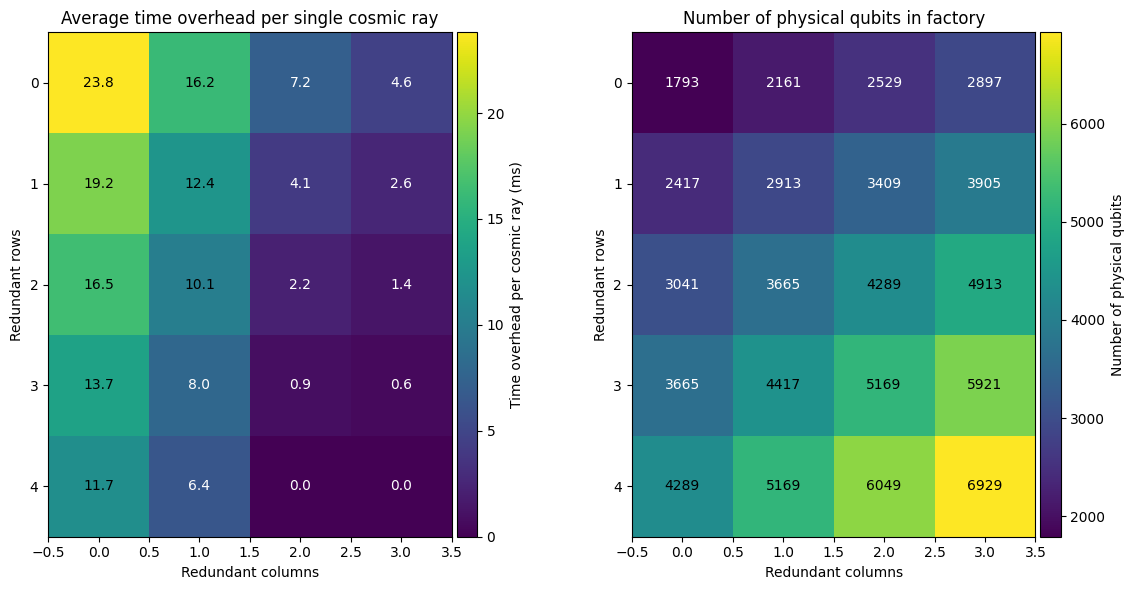

In [66]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ms_overheads = overheads*1e3

ax[0].imshow(ms_overheads)
ax[0].set_ylabel('Redundant rows')
ax[0].set_xlabel('Redundant columns')
ax[0].set_title('Average time overhead per single cosmic ray')
for (j,i),label in np.ndenumerate(ms_overheads):
    ax[0].text(i,j,f'{label:0.1f}',ha='center',va='center',color='white' if label < ms_overheads.mean() else 'black')
c = add_cbar(ax[0], mpl.colors.Normalize(vmin=ms_overheads.min(), vmax=ms_overheads.max()), 'viridis')
c.set_label('Time overhead per cosmic ray (ms)')

ax[1].imshow(space_costs)
ax[1].set_ylabel('Redundant rows')
ax[1].set_xlabel('Redundant columns')
ax[1].set_title('Number of physical qubits in factory')
for (j,i),label in np.ndenumerate(space_costs):
    ax[1].text(i,j,f'{int(label)}',ha='center',va='center',color='white' if label < space_costs.mean() else 'black')
c = add_cbar(ax[1], mpl.colors.Normalize(vmin=space_costs.min(), vmax=space_costs.max()), 'viridis')
c.set_label('Number of physical qubits')

plt.tight_layout()
plt.savefig('single_ray_overheads.png', dpi=300)

TODO: look at having multiple adjacent factories instead of / in addition to doing redundant
columns

